In [827]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [828]:
#importing the full Dataset
base_df = pd.read_csv('flight_dataset.csv')
print(base_df.shape)
base_df.head(2)

(300153, 13)


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,days_left
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy,1
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy,1


In [829]:
#Checking  if any null value is there in dataset
base_df.isnull().count()

date          300153
airline       300153
ch_code       300153
num_code      300153
dep_time      300153
from          300153
time_taken    300153
stop          300153
arr_time      300153
to            300153
price         300153
class         300153
days_left     300153
dtype: int64

Data Cleaning and formating

In [830]:
# it was observed that Stop column has a lot of redundant spaces.... therefore cleaning it
base_df['stop'] = base_df['stop'].str.strip()

In [831]:
#cleaning price by removing all ','
base_df['price'] = base_df['price'].str.replace(',', '').astype('int')

In [832]:
# Spliting  base data to train-test Data
X =base_df.drop('price', axis=1)
y =base_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [833]:
X_train.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,class,days_left
190583,07-03-2022,Indigo,6E,927,12:40,Chennai,05h 55m,1-stop,18:35,Mumbai,Economy,25
75456,19-03-2022,Vistara,UK,986,22:45,Mumbai,10h 55m,1-stop,09:40,Hyderabad,Economy,37
162785,13-03-2022,Air India,AI,840,20:50,Hyderabad,23h 10m,1-stop,20:00,Mumbai,Economy,31
286546,10-03-2022,Vistara,UK,876,21:35,Hyderabad,14h 15m,1-stop,11:50,Chennai,Business,28
195235,02-03-2022,Vistara,UK,836,10:45,Chennai,29h 15m,2+-stop,16:00,Bangalore,Economy,20


DATA PREPARATION

Adding and deleteing further information to clean the data

In [834]:
#Extracting Day & Month from Date column
def extracting_day_n_month_from_date(input_df:pd.DataFrame, input_dateCol:str ):
    input_df['day']   = input_df[input_dateCol].str[:2].astype('int')
    input_df['month'] = input_df[input_dateCol].str[3:5].astype('int')
    return input_df 


In [835]:
# extracting Hours from time
def extracting_hours_from_time(input_df:pd.DataFrame, input_hourCol:str, output_hourCol:str):
    input_df[output_hourCol] = input_df[input_hourCol].str[:2].astype('int')
    return input_df

In [836]:
def timing_conditions(x:int):
    if x < 4:
        return 'mid_night'
    elif x >= 4 and x < 8 :
        return 'early_morning'
    elif x >= 8 and x < 12 :
        return 'day'
    elif x >= 12 and x < 16 :
        return 'afternoon'
    elif x >= 16 and x < 20 :
        return 'evening'
    else:
        return 'night'
     


In [837]:
# journey time in minutes from time_taken
def journey_time_in_min(input_df:pd.DataFrame, input_col:str):
    input_df['time_taken_min'] = input_df[input_col].str[:2].astype('int') * 60 + input_df[input_col].str[4:6].astype('int')
    
    return input_df


In [838]:
#checking how many types of Stop is there in the data...
work_in_prog_df =  base_df
#work_in_prog_df.stop.unique().................. will not work bcz of redundant spaces
work_in_prog_df['stop_2'] = work_in_prog_df['stop'].str[:6] 
work_in_prog_df.stop_2.unique()

array(['non-st', '1-stop', '2+-sto'], dtype=object)

In [839]:
# clean Stop data
# stops are categorized in ... non-stop, 1-stop and multiple_stops
def condition_for_stops(x:str):
    if x[:8] == 'non-stop':
        return 0
    elif x[:6] == '1-stop':
        return 1
    else:
        return 2



In [840]:
#  ---------------  X_train cleaning --------------------------------- #

# Extracting Day & Month from Date column
X_train = extracting_day_n_month_from_date(X_train, 'date')

# extracting Hours from time
X_train = extracting_hours_from_time(X_train, 'dep_time', 'dep_hour')

# deriving at timing of the day.... Morning day night.. 
X_train['dep_timing'] = X_train['dep_hour'].apply(timing_conditions)

# journey time in minutes from time_taken
X_train = journey_time_in_min(X_train, 'time_taken')

# stops are categorized in ... non-stop, 1-stop and multiple_stops
X_train['stop'] = X_train['stop'].apply(condition_for_stops)

# Droping the redundant columns
dropable_col_list= ['date', 'ch_code', 'num_code', 'dep_time', 'time_taken', 'arr_time', 'dep_hour', 'day']
X_train.drop(dropable_col_list, axis=1, inplace=True)


In [841]:
#------------------- Encoding for x_train ------------------------------------------------------
# One hot encoding
X_train = pd.get_dummies(X_train, columns=['airline', 'from', 'to', 'dep_timing'], dtype='int') 

# Label encoding
class_labels = {'Economy':1, 'Business':2}
X_train.replace({'class': class_labels}, inplace=True)

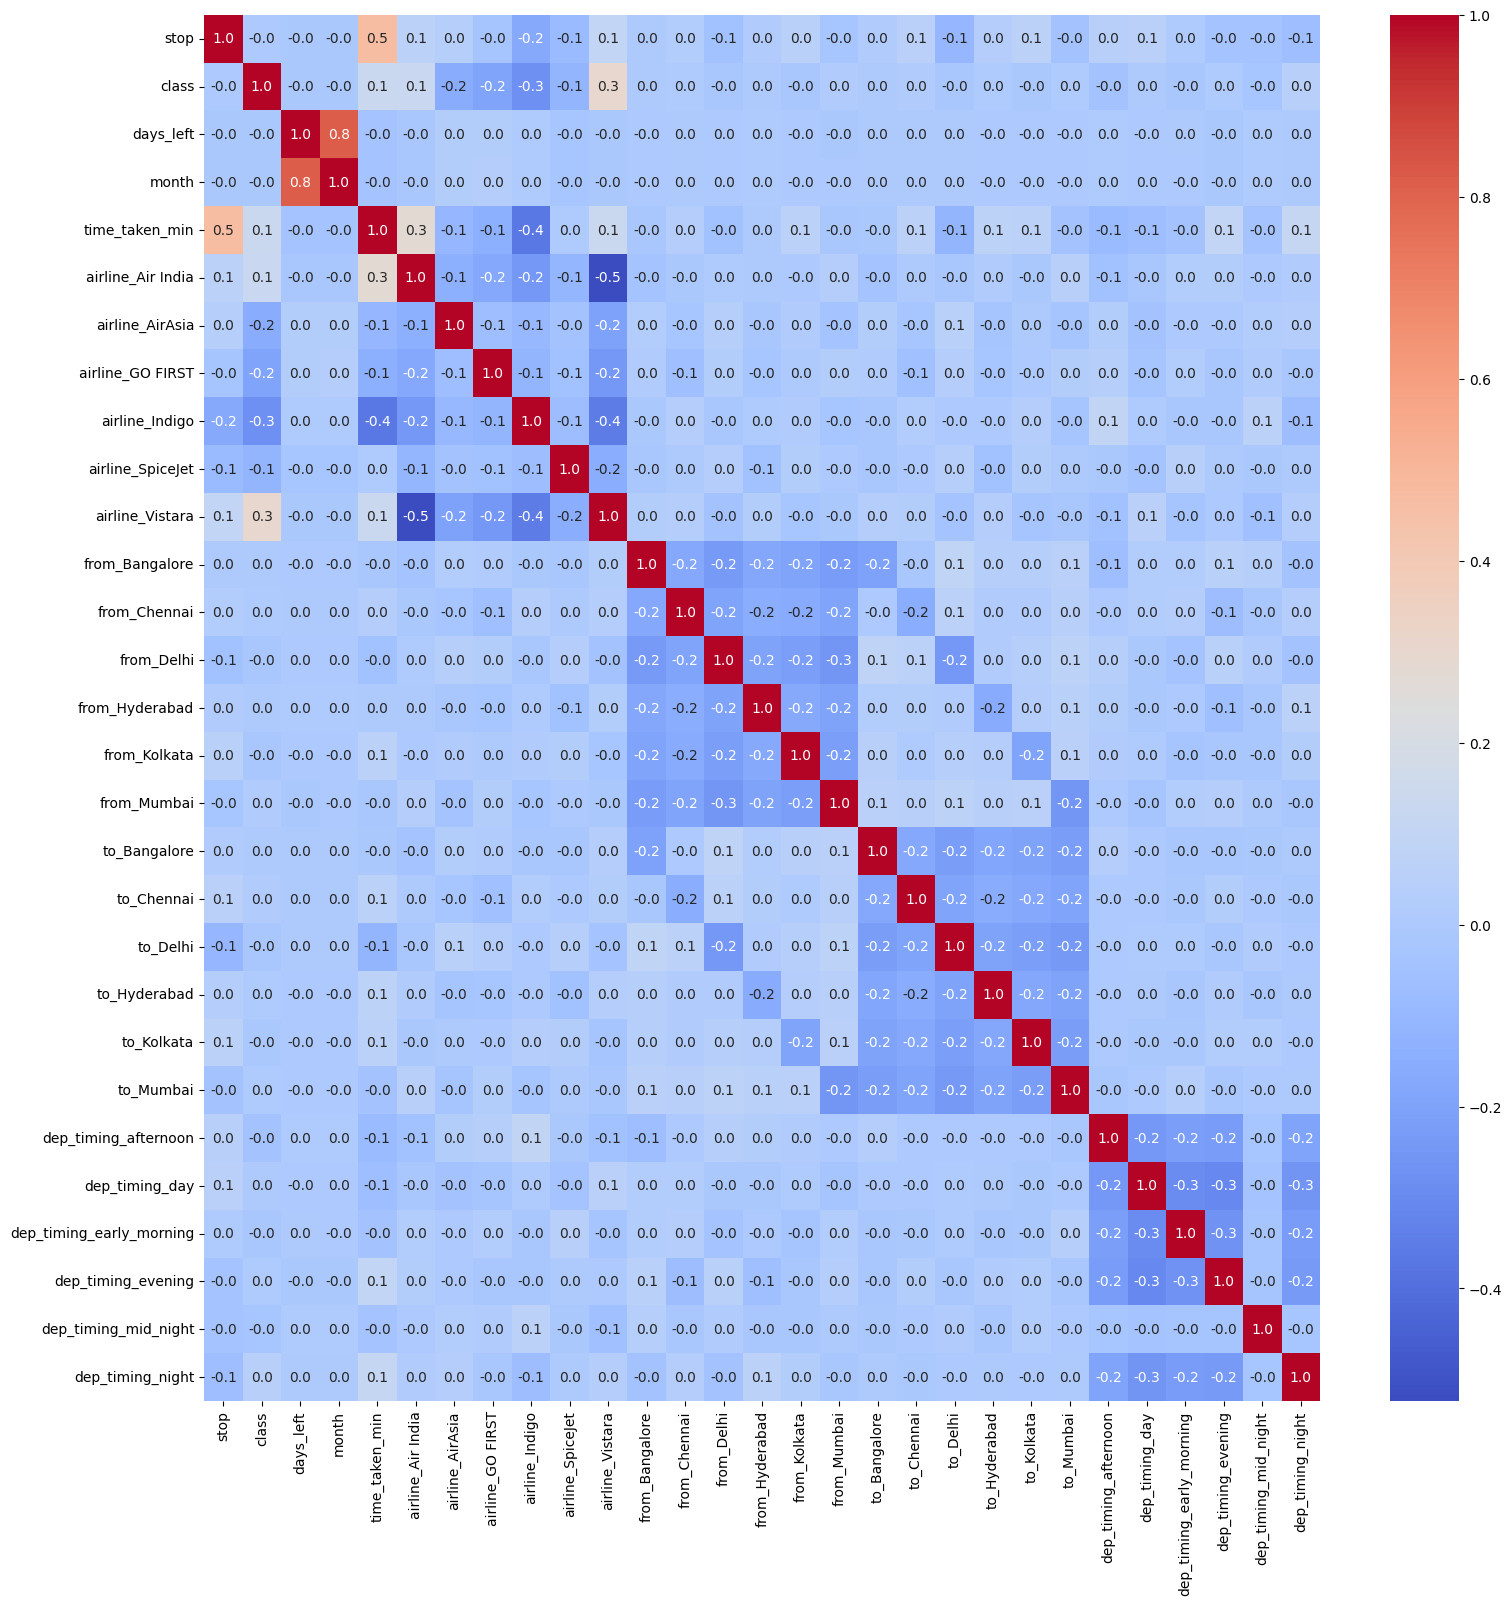

In [842]:
plt.figure(figsize = (18,18))
sns.heatmap(X_train.corr(), cmap = "coolwarm", annot=True, fmt=".1f")
plt.show()

'Months' 'days left' are highly corelated therefore need to drop 'month' column

In [843]:
X_train.drop(['month'], axis=1, inplace=True)

In [844]:
#X_train.drop(['class'], inplace=True, axis=1)

In [845]:
# from sklearn.ensemble import ExtraTreesRegressor
# selection = ExtraTreesRegressor()
# selection.fit(X_train,y_train)
# print(selection.feature_importances_)

In [846]:
# plt.figure(figsize=(12,8))
# X_train_features = X_train.columns

# feat_importances = pd.Series(selection.feature_importances_, index = X_train_features)
# feat_importances.nlargest(20).plot(kind='barh')
# plt.show()

In [847]:
#  ---------------  X_test cleaning --------------------------------- #

# Extracting Day & Month from Date column
X_test = extracting_day_n_month_from_date(X_test, 'date')

# extracting Hours from time
X_test = extracting_hours_from_time(X_test, 'dep_time', 'dep_hour')

# deriving at timing of the day.... Morning day night.. 
X_test['dep_timing'] = X_test['dep_hour'].apply(timing_conditions)

# journey time in minutes from time_taken
X_test = journey_time_in_min(X_test, 'time_taken')

# stops are categorized in ... non-stop, 1-stop and multiple_stops
X_test['stop'] = X_test['stop'].apply(condition_for_stops)

# Droping the redundant columns
dropable_col_list= ['date', 'ch_code', 'num_code', 'dep_time', 'time_taken', 'arr_time', 'dep_hour','month', 'day']
X_test.drop(dropable_col_list, axis=1, inplace=True)

In [848]:
#------------------- Encoding for X_test ------------------------------------------------------
# One hot encoding
X_test = pd.get_dummies(X_test, columns=['airline', 'from', 'to', 'dep_timing'], dtype='int') 

# Label encoding
class_labels = {'Economy':1, 'Business':2}
X_test.replace({'class': class_labels}, inplace=True)

Model Building

In [849]:
# importing Models from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRFRegressor

In [850]:
# defining models
lenear_regression = LinearRegression()
knn             = KNeighborsRegressor(n_neighbors=10)
decision_tree   = DecisionTreeRegressor(max_depth = 3)
random_forest   = RandomForestRegressor(max_depth = 3, n_estimators=500)
ada_boost       = AdaBoostRegressor( n_estimators=50, learning_rate =.01)
#gbr = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate =.2)

In [851]:
models = {
    'lenear_regression':    LinearRegression(),
    'decision_tree' :       KNeighborsRegressor(n_neighbors=10),
    'random_forest':        DecisionTreeRegressor(max_depth = 3),
    'ada_boost':            RandomForestRegressor(max_depth = 3, n_estimators=500),
    'knn':                  AdaBoostRegressor( n_estimators=50, learning_rate =.01)
}

In [852]:
from sklearn.metrics import r2_score

# function for running each model
def model_output(input_model):
    input_model.fit(X_train, y_train)
    y_pred = input_model.predict(X_test)
    r1 = r2_score(y_test, y_pred)
    return [r1, y_pred]
    

In [853]:
# Looping through models
outputs_r1 = {}
outputs_y_pred = {}
for key in models:
    ths_model = models[key]
    rslt = model_output(ths_model)
    outputs_r1[key] = rslt[0]
    outputs_y_pred[key] = rslt[1]


In [854]:
# before using the scaler
outputs_r1

{'lenear_regression': 0.9098631041577059,
 'decision_tree': 0.4960187254140903,
 'random_forest': 0.9347259089518486,
 'ada_boost': 0.9347720027429632,
 'knn': 0.9347009836461186}

In [855]:
# Using standard scaler
# Scaling Data

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test) 

In [856]:
# lenear_reg = LinearRegression()
# lenear_reg.fit(X_train, y_train)
# y_pred = lenear_reg.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# r2

In [857]:
selected_method = 'lenear_regression'
y_pred =  outputs_y_pred[selected_method]

prediction= pd.DataFrame({
    'actual_price': y_test, 
    'predicted_price': y_pred
    })



In [858]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 4515.281063993902
MSE: 46504170.77053288
RMSE: 6819.3966573688085


c:\Users\koust\PycharmProjects\pythonProject\Flight_Booking_project\.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


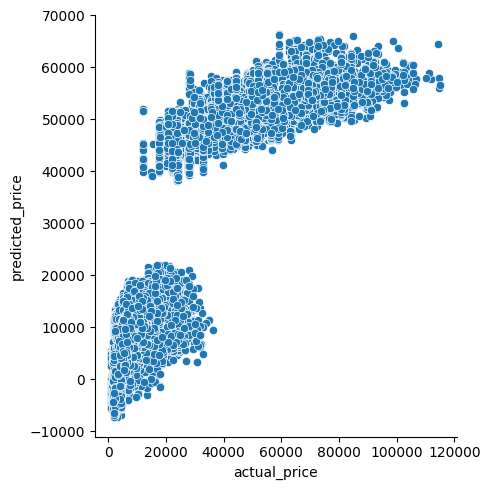

In [859]:
sns.relplot(data=prediction, x='actual_price', y='predicted_price')

C:\Users\koust\AppData\Local\Temp\ipykernel_6724\1503775495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


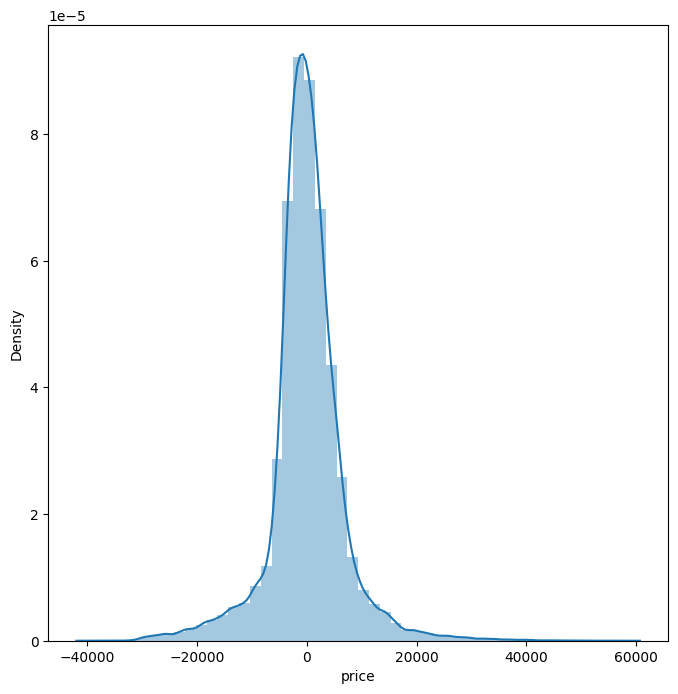

In [860]:

plt.figure(figsize = (8,8))
sns.distplot(y_test - y_pred)
plt.show()

# WORK -- IN -- PROGRESS

In [861]:
X_train.head()

,stop,class,days_left,time_taken_min,airline_Air India,airline_AirAsia,airline_GO FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,...,to_Delhi,to_Hyderabad,to_Kolkata,to_Mumbai,dep_timing_afternoon,dep_timing_day,dep_timing_early_morning,dep_timing_evening,dep_timing_mid_night,dep_timing_night
190583,1,1,25,355,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
75456,1,1,37,655,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
162785,1,1,31,1390,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
286546,1,2,28,855,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
195235,2,1,20,1755,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [862]:
X_test.head()

,stop,class,days_left,time_taken_min,airline_Air India,airline_AirAsia,airline_GO FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,...,to_Delhi,to_Hyderabad,to_Kolkata,to_Mumbai,dep_timing_afternoon,dep_timing_day,dep_timing_early_morning,dep_timing_evening,dep_timing_mid_night,dep_timing_night
27131,1,1,40,1185,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
266857,1,2,42,590,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
141228,1,1,41,630,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
288329,1,2,14,870,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
97334,1,1,20,495,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
